In [2]:
import numpy as np

In [3]:
import cv2

In [4]:
import os
from matplotlib import pyplot as plt 

In [5]:
import time

In [6]:
import mediapipe as mp

In [7]:
mp_holistic = mp.solutions.holistic

In [8]:
mp_drawing = mp.solutions.drawing_utils

In [9]:
def mediapipe_detection(image, model):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model.process(image_rgb)
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    return image_bgr, results

def draw_styled_landmarks(image, results):
    drawing_specs = [
        mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
        mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1),
        mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2),
        mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2),
        mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
    ]

    # Draw face, pose, and hand connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, landmark_drawing_spec=drawing_specs[0], connection_drawing_spec=drawing_specs[1])
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, landmark_drawing_spec=drawing_specs[2], connection_drawing_spec=drawing_specs[3])
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, landmark_drawing_spec=drawing_specs[4], connection_drawing_spec=drawing_specs[5])
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, landmark_drawing_spec=drawing_specs[6], connection_drawing_spec=drawing_specs[7])

cap = cv2.VideoCapture(0)

detected_landmarks_counts = []

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)
        
        cv2.imshow('OpenCV Feed', image)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
    

cap.release()
cv2.destroyAllWindows()

print(results)


<class 'mediapipe.python.solution_base.SolutionOutputs'>


In [10]:
draw_styled_landmarks(frame, results)

In [11]:
results

mediapipe.python.solution_base.SolutionOutputs

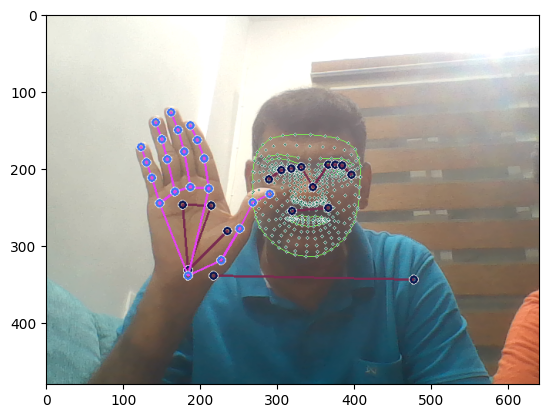

In [12]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [13]:
len(results.left_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

In [14]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [15]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [16]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)


In [17]:
face

array([ 0.53261232,  0.54822552, -0.0221666 , ...,  0.60423118,
        0.42665237,  0.01076071])

In [18]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [19]:
result_test = extract_keypoints(results)

In [20]:
result_test

array([ 0.54143041,  0.46847206, -0.72314703, ...,  0.1934308 ,
        0.36009836, -0.03662935])

In [21]:
np.save('0', result_test)

In [22]:
np.load('0.npy')

array([ 0.54143041,  0.46847206, -0.72314703, ...,  0.1934308 ,
        0.36009836, -0.03662935])

# 4.  SETUP FOLDERS FOR COLLECTION

In [23]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks','good','welcome','sorry'])

# Thirty videos worth of data
no_sequences = 20

# Videos are going to be 30 frames in length
sequence_length = 20

In [24]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. COLLECT KEYPOINTS VALUES FOR TRAINING AND TESTING

In [25]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# 6. PREPROCESS DATA AND CREATE LABELS AND FEATURES

In [26]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [27]:
label_map = {label:num for num, label in enumerate(actions)}

In [28]:
label_map

{'hello': 0, 'thanks': 1, 'good': 2, 'welcome': 3, 'sorry': 4}

In [29]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [30]:
np.array(sequences).shape

(100, 20, 1662)

In [31]:
np.array(labels).shape

(100,)

In [32]:
X = np.array(sequences)

In [33]:
X.shape

(100, 20, 1662)

In [34]:
y = to_categorical(labels).astype(int)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [36]:
y_test.shape

(5, 5)

# 7. BUILD AND TRAIN LSTM MODEL

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [38]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [39]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(20,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [40]:
res = [.7, 0.2, 0.1]

In [41]:
actions[np.argmax(res)]

'hello'

In [42]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [43]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 5s 67ms/step - loss: 1.6569 - categorical_accuracy: 0.1684
Epoch 2/2000
3/3 [==============================] - 0s 70ms/step - loss: 1.6883 - categorical_accuracy: 0.2105
Epoch 3/2000
3/3 [==============================] - 0s 62ms/step - loss: 1.7355 - categorical_accuracy: 0.3053
Epoch 4/2000
3/3 [==============================] - 0s 64ms/step - loss: 1.8518 - categorical_accuracy: 0.1579
Epoch 5/2000
3/3 [==============================] - 0s 61ms/step - loss: 1.6396 - categorical_accuracy: 0.2000
Epoch 6/2000
3/3 [==============================] - 0s 58ms/step - loss: 1.5781 - categorical_accuracy: 0.2526
Epoch 7/2000
3/3 [==============================] - 0s 58ms/step - loss: 1.5438 - categorical_accuracy: 0.3579
Epoch 8/2000
3/3 [==============================] - 0s 61ms/step - loss: 1.3453 - categorical_accuracy: 0.4947
Epoch 9/2000
3/3 [==============================] - 0s 63ms/step - loss: 1.3708 - categorical_accuracy: 0.3474
E

3/3 [==============================] - 0s 126ms/step - loss: 3.5957e-04 - categorical_accuracy: 1.0000
Epoch 74/2000
3/3 [==============================] - 0s 125ms/step - loss: 3.2478e-04 - categorical_accuracy: 1.0000
Epoch 75/2000
3/3 [==============================] - 0s 124ms/step - loss: 3.2924e-04 - categorical_accuracy: 1.0000
Epoch 76/2000
3/3 [==============================] - 0s 117ms/step - loss: 3.4457e-04 - categorical_accuracy: 1.0000
Epoch 77/2000
3/3 [==============================] - 0s 98ms/step - loss: 3.0957e-04 - categorical_accuracy: 1.0000
Epoch 78/2000
3/3 [==============================] - 0s 102ms/step - loss: 2.6668e-04 - categorical_accuracy: 1.0000
Epoch 79/2000
3/3 [==============================] - 0s 113ms/step - loss: 2.8600e-04 - categorical_accuracy: 1.0000
Epoch 80/2000
3/3 [==============================] - 0s 112ms/step - loss: 2.7227e-04 - categorical_accuracy: 1.0000
Epoch 81/2000
3/3 [==============================] - 0s 103ms/step - loss: 2.57

KeyboardInterrupt: 

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 596741 (2.28 MB)
Trainable params: 596741 

# 8.Make predictions

In [45]:
res = model.predict(X_test)

1/1 [==============================] - 0s 436ms/step


In [46]:
actions[np.argmax(res[4])]

'sorry'

In [47]:
actions[np.argmax(y_test[4])]

'sorry'

# 9.Save Weights

In [48]:
model.save('action.h5')

C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 10. Evaluation using confusion matrix accuracy

In [49]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [50]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 36ms/step


In [51]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [52]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [53]:
accuracy_score(ytrue, yhat)

1.0

# 11.TEST IN REAL TIME

In [54]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (245, 16, 117), (117, 16, 245), (16, 245, 117)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [55]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-20:]

        if len(sequence) == 20:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])

            # 3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 6:  # Adjust to 6 signs
                sentence = sentence[-6:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to the screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 27ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
thanks
<class 'media

1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 35ms/step
welcome
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
welcome
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
welcome
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
welcome
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
welcome
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
welcome
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
welcome
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
welcome
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
welcome
<cla

1/1 [==============================] - 0s 37ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
sorry
<class 'mediapipe.pyth

1/1 [==============================] - 0s 31ms/step
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
good
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
good
<class 'mediapipe.python.soluti

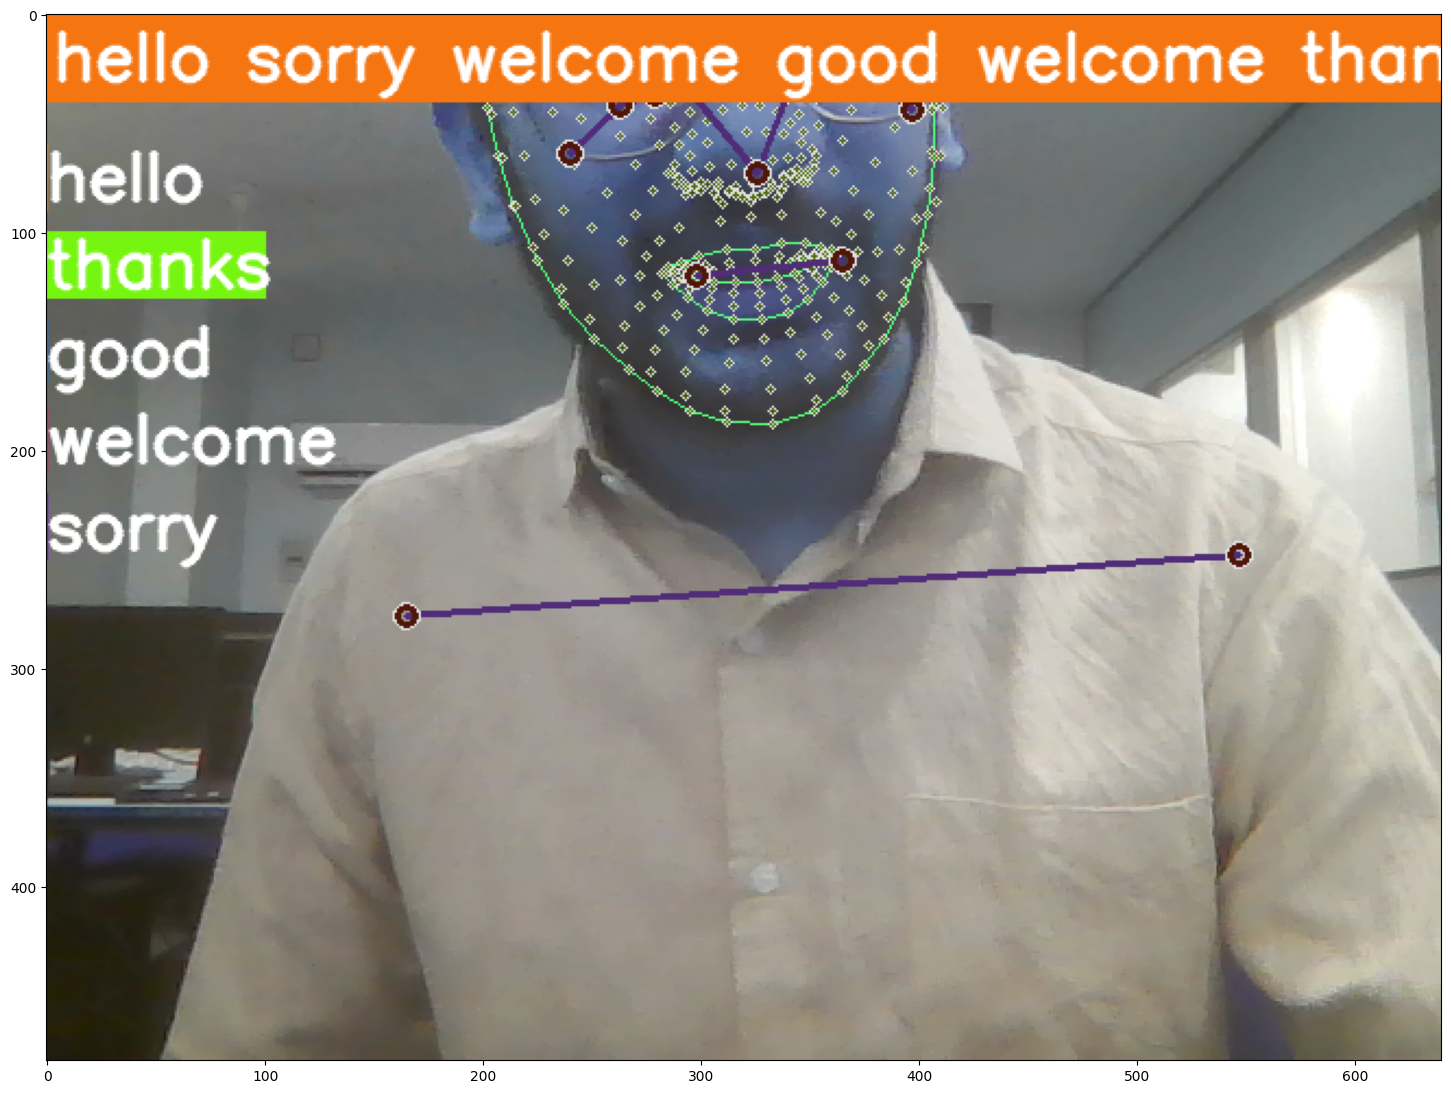

In [62]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [63]:
sequence.reverse()

In [56]:
len(sequence)

20

In [57]:
sequence.append('def')

In [58]:
sequence.reverse()

In [61]:
sequence[-20:]

[array([ 0.52922797,  0.34746724, -0.70034677, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.52918911,  0.34771672, -0.70445746, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.52918565,  0.34879991, -0.70187414, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.5291335 ,  0.34985322, -0.70361483, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.52911675,  0.35221955, -0.70537239, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.52939999,  0.35225773, -0.73976815, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.52930248,  0.35250312, -0.76419848, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.52987409,  0.35295811, -0.77824622, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.53048116,  0.35321254, -0.77430803, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.53036702,  0.35320675, -0.76919204, ...,  0.        ,
         0.        ,  0.  

In [59]:
res[np.argmax(res)] > threshold

True

In [60]:
model.predict(np.expand_dims(X_test[0], axis=0))

1/1 [==============================] - 0s 18ms/step


array([[9.9999881e-01, 8.3221569e-16, 2.8711490e-24, 7.8941742e-18,
        1.1964878e-06]], dtype=float32)